In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='6'
import time
import numpy as np
import tensorflow as tf
from VGG16_GAP import VGG16_GAP
# from VGG16_flatten import VGG16_flatten

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import pandas as pd
import skimage.io as imageio
import pickle

In [3]:
# from progress.bar import Bar
# from ipywidgets import IntProgress
# from IPython.display import display

In [4]:
with open('/home/cclin/ntu/dlcv2018/DLCV2018SPRING/final/label_dict.pkl', 'rb') as f:
    y_dict = pickle.load(f)

with open('/home/cclin/ntu/dlcv2018/DLCV2018SPRING/final/inv_label_dict.pkl', 'rb') as f:
    inv_y_dict = pickle.load(f)

In [5]:
# with open('save/inv_label_dict.pkl', 'rb') as f:
#     inv_y_dict = pickle.load(f)

In [6]:
HOME_DIR = "/data/put_data/cclin/ntu/dlcv2018/final/"
TRAIN_DIR = HOME_DIR+"dlcv_final_2_dataset/train/"
VALID_DIR = HOME_DIR+"dlcv_final_2_dataset/val/"
TEST_DIR = HOME_DIR+"dlcv_final_2_dataset/test/"

In [7]:
dtrain = pd.read_csv(HOME_DIR+"dlcv_final_2_dataset/train_id.txt", header=None,sep=" ", names=["img", "id"])
dvalid = pd.read_csv(HOME_DIR+"dlcv_final_2_dataset/val_id.txt", header=None,sep=" ", names=["img", "id"])

In [8]:
train_list = list(TRAIN_DIR+dtrain.img)
valid_list = list(VALID_DIR+dvalid.img)

In [9]:
test_list = list()
for root, subdir, files in os.walk(TEST_DIR):
    for file in sorted(files):
        if '.jpg' in file:
            test_list.append(os.path.join(TEST_DIR, file))

In [10]:
def readImgList(file_list):
    images = list()
    for i, file in enumerate(file_list):
        print(i, end="\r")
        img = imageio.imread(file)
        img = img.astype(int)
        images.append(img)
    return np.array(images)

In [11]:
def transformLabel(id_list, y_dict):
    label = list()
    for uid in list(id_list):
        label.append(y_dict[uid])
    return np.array(label)

In [12]:
def one_hot_encoding(class_numbers, num_classes):
    return np.eye(num_classes, dtype=float)[class_numbers]

In [13]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v,f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars): 
            sess.run(tf.variables_initializer(not_initialized_vars))

In [14]:
Xtrain = readImgList(train_list)
print("train:", Xtrain.shape)

train: (56475, 218, 178, 3)


In [15]:
Xvalid = readImgList(valid_list)
print("valid:", Xvalid.shape)

valid: (7211, 218, 178, 3)


In [16]:
Xtest = readImgList(test_list)
print("valid:", Xtest.shape)

valid: (7152, 218, 178, 3)


In [17]:
ytrain = transformLabel(list(dtrain.id), y_dict)

In [18]:
yvalid = transformLabel(list(dvalid.id), y_dict)

In [19]:
Ytrain = one_hot_encoding(ytrain, len(y_dict))
Yvalid = one_hot_encoding(yvalid, len(y_dict))

In [20]:
scope_name = "Model"

In [21]:
model = VGG16_GAP(scope_name=scope_name)

In [22]:
FLAG_save_dir = "/data/put_data/cmchang/DLCV_final/newCL_v2_lambda-1e-1_dynamic_gap_L5_v3_rescale0-1_save_linear/"
FLAG_init_from = FLAG_save_dir + "para_dict.npy"

In [23]:
model.build(vgg16_npy_path=FLAG_init_from,
            shape=Xtrain.shape[1:],
            classes=len(y_dict),
            conv_pre_training=True,
            fc_pre_training=True,
            new_bn=False)

build model started
npy file loaded
build model finished: 0s


In [24]:
dp = [1.0]
model.set_idp_operation(dp=dp)

DP under test: [1.]
[None, 218, 178, 3]
[None, 218, 178, 32]
AFTER [None, 218, 178, 32]
[None, 109, 89, 47]
AFTER [None, 109, 89, 47]
[None, 109, 89, 63]
AFTER [None, 109, 89, 63]
[None, 55, 45, 98]
AFTER [None, 55, 45, 98]
[None, 55, 45, 134]
AFTER [None, 55, 45, 134]
[None, 55, 45, 147]
AFTER [None, 55, 45, 147]
[None, 28, 23, 153]
AFTER [None, 28, 23, 153]
[None, 28, 23, 209]
AFTER [None, 28, 23, 209]
[None, 28, 23, 181]
AFTER [None, 28, 23, 181]
[None, 14, 12, 177]
AFTER [None, 14, 12, 177]
[None, 14, 12, 180]
AFTER [None, 14, 12, 180]
[None, 14, 12, 230]
AFTER [None, 14, 12, 230]
Set dp operations finished: 0s


In [25]:
def count_number_params(para_dict):
    n = 0
    for k,v in sorted(para_dict.items()):
        if 'bn_mean' in k:
            continue
        elif 'bn_variance' in k:
            continue
        elif 'gamma' in k:
            continue
        elif 'beta' in k:
            continue
        elif 'conv' in k or 'fc' in k:
            n += get_params_shape(v[0].shape.as_list())
            n += get_params_shape(v[1].shape.as_list())
    return n

def get_params_shape(shape):
    n = 1
    for dim in shape:
        n = n*dim
    return n

def count_flops(para_dict, net_shape, input_shape=(3, 218, 178)):
    # Format:(channels, rows,cols)
    total_flops_per_layer = 0
    input_count = 0
    for k,v in sorted(para_dict.items()):
        if 'bn_mean' in k:
            continue
        elif 'bn_variance' in k:
            continue
        elif 'gamma' in k:
            continue
        elif 'beta' in k:
            continue
        elif 'fc' in k:
            continue
        elif 'conv' in k:
            conv_filter = v[0].shape.as_list()[3::-1] # (64 ,3 ,3 ,3)  # Format: (num_filters, channels, rows, cols)
            stride = 1
            padding = 1

            if conv_filter[1] == 0:
                n = conv_filter[2] * conv_filter[3] # vector_length
            else:
                n = conv_filter[1] * conv_filter[2] * conv_filter[3]  # vector_length

            flops_per_instance = n + ( n -1)    # general defination for number of flops (n: multiplications and n-1: additions)

            num_instances_per_filter = (( input_shape[1] - conv_filter[2] + 2 * padding) / stride) + 1  # for rows
            num_instances_per_filter *= ((input_shape[2] - conv_filter[3] + 2 * padding) / stride) + 1  # multiplying with cols

            flops_per_filter = num_instances_per_filter * flops_per_instance
            total_flops_per_layer += flops_per_filter * conv_filter[0]  # multiply with number of filters

            total_flops_per_layer += conv_filter[0] * input_shape[1] * input_shape[2] # bias

            input_shape = net_shape[input_count].as_list()[3:0:-1]
            input_count +=1

    total_flops_per_layer += net_shape[-1].as_list()[1] *2360*2
    return total_flops_per_layer

def countFlopsParas(net):
    total_flops = count_flops(net.para_dict, net.net_shape)
    if total_flops / 1e9 > 1:   # for Giga Flops
        print(total_flops/ 1e9 ,'{}'.format('GFlops'))
    else:
        print(total_flops / 1e6 ,'{}'.format('MFlops'))

    total_params = count_number_params(net.para_dict)

    if total_params / 1e9 > 1:   # for Giga Flops
        print(total_params/ 1e9 ,'{}'.format('G'))
    else:
        print(total_params / 1e6 ,'{}'.format('M'))
    
    return total_flops, total_params

In [26]:
flops, params = countFlopsParas(model)
FLAG_flops_M = flops/1e6
FLAG_params_M = params/1e6
print("Flops: %3f M, Paras: %3f M" % (flops/1e6, params/1e6))

6.875544996 GFlops
4.048755 M
Flops: 6875.544996 M, Paras: 4.048755 M


In [27]:
# extract features
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.global_variables())
    print("Initialized")
    output_train = []
    output_valid = []
    output_test = []
    for i in range(int(Xtrain.shape[0]/200+1)):
        print(i, end="\r")
        st = i*200
        ed = min((i+1)*200, Xtrain.shape[0])
        prob = sess.run(model.features, feed_dict={model.x: Xtrain[st:ed,:], 
                                                    model.is_train: False})
        output_train.append(prob)
    print()
    
    for i in range(int(Xvalid.shape[0]/200+1)):
        print(i, end="\r")
        st = i*200
        ed = min((i+1)*200, Xvalid.shape[0])
        prob = sess.run(model.features, feed_dict={model.x: Xvalid[st:ed,:], 
                                                    model.is_train: False})
        output_valid.append(prob)
    print()
    
    for i in range(int(Xtest.shape[0]/200+1)):
        print(i, end="\r")
        st = i*200
        ed = min((i+1)*200, Xtest.shape[0])
        prob = sess.run(model.features, feed_dict={model.x: Xtest[st:ed,:], 
                                                    model.is_train: False})
        output_test.append(prob)

Initialized
282
36


### compute center and cosine similarity

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import re

print(re.split(pattern='\/', string=FLAG_save_dir))
basic_model_name = re.split(pattern='\/', string=FLAG_save_dir)[-2]
print(basic_model_name)

saved_path = os.path.join('/data/put_data/cclin/ntu/dlcv2018/final/results', basic_model_name)
if not os.path.exists(saved_path):
    os.makedirs(saved_path)

['', 'data', 'put_data', 'cmchang', 'DLCV_final', 'newCL_v2_lambda-1e-1_dynamic_gap_L5_v3_rescale0-1_save_linear', '']
newCL_v2_lambda-1e-1_dynamic_gap_L5_v3_rescale0-1_save_linear


In [29]:
EX_train = np.concatenate(output_train,)
print(EX_train.shape)

(56475, 423)


In [30]:
EX_valid = np.concatenate(output_valid,)
print(EX_valid.shape)

(7211, 423)


In [31]:
EX_test = np.concatenate(output_test,)
print(EX_test.shape)

(7152, 423)


In [32]:
np.save(os.path.join(saved_path, 'EX_train.npy'), EX_train)
np.save(os.path.join(saved_path, 'EX_valid.npy'), EX_valid)
np.save(os.path.join(saved_path, 'EX_test.npy'), EX_test)

#### (1) validation

In [33]:
centers = np.zeros((len(y_dict), EX_train.shape[1]))
for i in range(len(y_dict)):
    centers[i,:] = np.mean(EX_train[ytrain==i,:], axis=0)

In [34]:
centers.shape

(2360, 423)

In [35]:
# np.save(arr=centers,file=FLAG_save_dir+"centers.npy")

In [36]:
cos_sim = cosine_similarity(EX_valid, centers)
print(cos_sim.shape)
pred_valid = np.argmax(cos_sim, axis=1)
print(pred_valid.shape)

(7211, 2360)
(7211,)


In [37]:
accuracy_score(list(yvalid), list(pred_valid))

0.8374705311329913

#### (2) testing

In [38]:
EX_all = np.concatenate((EX_train, EX_valid))
print(EX_all.shape)

(63686, 423)


In [39]:
Y = np.concatenate([ytrain, yvalid])
print(Y.shape)

(63686,)


In [40]:
centers_all = np.zeros((len(y_dict), EX_all.shape[1]))
for i in range(len(y_dict)):
    centers_all[i,:] = np.mean(EX_all[Y==i,:], axis=0)

In [41]:
centers_all.shape

(2360, 423)

In [42]:
cos_sim = cosine_similarity(EX_test, centers_all)
print(cos_sim.shape)
pred_test = np.argmax(cos_sim, axis=1)
print(pred_test.shape)

(7152, 2360)
(7152,)


In [43]:
final_id = list()
for pred in pred_test:
    final_id.append(inv_y_dict[pred])

In [44]:
doutput = pd.DataFrame({'id':np.arange(len(final_id))+1, 'ans':final_id}, columns=['id','ans'])

In [46]:
output_name = "cos_pred_val83_" + basic_model_name + ".csv"
print(output_name)

cos_pred_val83_newCL_v2_lambda-1e-1_dynamic_gap_L5_v3_rescale0-1_save_linear.csv


In [47]:
doutput.to_csv(output_name, index=False)

### backup: KNN

In [38]:
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=1)
# neigh.fit(centers, np.arange(len(y_dict)))
# pred_valid = neigh.predict(EX_valid)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

### Error Analysis

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import compress
from scipy.stats.stats import pearsonr
from shutil import copyfile

#### (0) accuracy per class

In [49]:
accuracy_per_class = []
for i in range(len(y_dict)):
    accuracy_per_class.append(accuracy_score(list(yvalid[yvalid==i]), list(pred_valid[yvalid==i])))

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


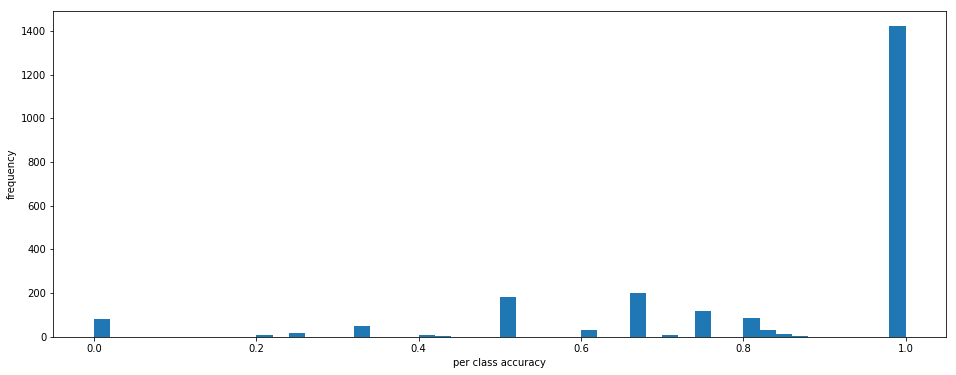

In [50]:
## remove nan accuracy
accuracy_per_class_ = list(compress(accuracy_per_class, list(~np.isnan(accuracy_per_class))))

fig, ax = plt.subplots(figsize=(16,6))
ax.hist(accuracy_per_class_, bins=50)
ax.set_title('')
ax.set_xlabel('per class accuracy')
ax.set_ylabel('frequency')
plt.show()
# fig.savefig(dir_name+'/outputs/ave_generated_vs_real.png')
plt.close(fig)

#### (1) accuracy vs. number of training/validation data

In [51]:
n_train_file = []
n_valid_file = []
for i in range(len(accuracy_per_class)):
    dtrain_temp = dtrain.query('id == '+str(inv_y_dict[i]))
    train_list_temp = list(TRAIN_DIR+dtrain_temp.img)
    n_train_file.append(len(train_list_temp))
    dvalid_temp = dvalid.query('id == '+str(inv_y_dict[i]))
    valid_list_temp = list(VALID_DIR+dvalid_temp.img)
    n_valid_file.append(len(valid_list_temp))

In [52]:
## remove rows with nan accuracy
n_train_file_ = list(compress(n_train_file, list(~np.isnan(accuracy_per_class))))
n_valid_file_ = list(compress(n_valid_file, list(~np.isnan(accuracy_per_class))))

In [53]:
## compute correlation between number
print(pearsonr(n_train_file_, accuracy_per_class_))
print(pearsonr(n_valid_file_, accuracy_per_class_))

(0.02904605653881193, 0.16672475141733487)
(0.004019039117950236, 0.8482936476169467)


#### (2) copy images of bad classes

In [54]:
count = 0
acc_threshold = 0.2

bad_path = os.path.join(saved_path, 'bad')
if not os.path.exists(bad_path):
    os.makedirs(bad_path)

for i in range(len(accuracy_per_class)):
    if accuracy_per_class[i] < acc_threshold:
        count += 1
        bad_class_path = os.path.join(bad_path, str(inv_y_dict[i]))
        if not os.path.exists(bad_class_path):
            os.makedirs(bad_class_path)
            bad_train_path = os.path.join(bad_class_path, 'train')
            os.makedirs(bad_train_path)
            bad_valid_path = os.path.join(bad_class_path, 'valid')
            os.makedirs(bad_valid_path)
        dtrain_temp = dtrain.query('id == '+str(inv_y_dict[i]))
        train_list_temp = list(TRAIN_DIR+dtrain_temp.img)
        for img in train_list_temp:
            copyfile(img, os.path.join(bad_train_path, os.path.basename(img)))
        dvalid_temp = dvalid.query('id == '+str(inv_y_dict[i]))
        valid_list_temp = list(VALID_DIR+dvalid_temp.img)
        for img in valid_list_temp:
            copyfile(img, os.path.join(bad_valid_path, os.path.basename(img)))
        print('index = %d, label = %d, valid accuracy = %.4f, n.train.file = %d, n.valid.file = %d' % \
              (i, inv_y_dict[i], accuracy_per_class[i], len(train_list_temp), len(valid_list_temp)))
print('count = %d' % count)

index = 30, label = 220, valid accuracy = 0.0000, n.train.file = 24, n.valid.file = 1
index = 59, label = 433, valid accuracy = 0.0000, n.train.file = 26, n.valid.file = 2
index = 95, label = 844, valid accuracy = 0.0000, n.train.file = 25, n.valid.file = 1
index = 118, label = 997, valid accuracy = 0.0000, n.train.file = 26, n.valid.file = 1
index = 123, label = 1018, valid accuracy = 0.0000, n.train.file = 28, n.valid.file = 1
index = 141, label = 1066, valid accuracy = 0.0000, n.train.file = 26, n.valid.file = 1
index = 143, label = 1089, valid accuracy = 0.0000, n.train.file = 26, n.valid.file = 1
index = 173, label = 1221, valid accuracy = 0.0000, n.train.file = 24, n.valid.file = 2
index = 203, label = 1322, valid accuracy = 0.0000, n.train.file = 26, n.valid.file = 1
index = 250, label = 1470, valid accuracy = 0.0000, n.train.file = 26, n.valid.file = 1
index = 289, label = 1589, valid accuracy = 0.0000, n.train.file = 29, n.valid.file = 1
index = 293, label = 1603, valid accura